In [2]:
import pandas as pd

columns = ["ts", "IDC", "IAC"]
#file_path = r'..\0_raw\dmm_data6894024_2022_05_27_212453_all.dat' # este no calza con ningun beam data por los tiempos
file_path = r'..\0_raw\dmm_data_2022_06_02-14_all.dat'

#Abro el fichero, reemplazo los '\x00' y guardo en memoria
with open(file_path, 'r', encoding='latin-1', errors='ignore') as f:
    text = f.read().replace('\x00', '')

from io import StringIO
df = pd.read_csv(
    StringIO(text),
    delim_whitespace=True,
    names=columns,
    comment="#",
    engine="python"
)



In [3]:
df.head()

,ts,IDC,IAC
0,1.654078e+09,0.6231,0.000012
1,1.654078e+09,0.6231,0.000012
2,1.654078e+09,0.6202,0.000012
3,1.654078e+09,0.6202,0.000012
4,1.654078e+09,0.6231,0.000012


In [4]:
# time stamps
df["time"] = pd.to_datetime(df["ts"], unit="s") + pd.Timedelta(hours=2)
df = df.set_index("time")

# Integridad
print(df.isna().sum())                     # Buscar NaN
print(df.index.to_series().diff().describe())  # Revisar intervalos de ~4 s


ts     0
IDC    0
IAC    0
dtype: int64
count                       273857
mean     0 days 00:00:04.248861707
std      0 days 00:00:30.843098908
min      0 days 00:00:04.079984896
25%      0 days 00:00:04.100334848
50%      0 days 00:00:04.106866176
75%      0 days 00:00:04.173525248
max      0 days 02:41:50.620609280
Name: time, dtype: object


## Graph Analysis

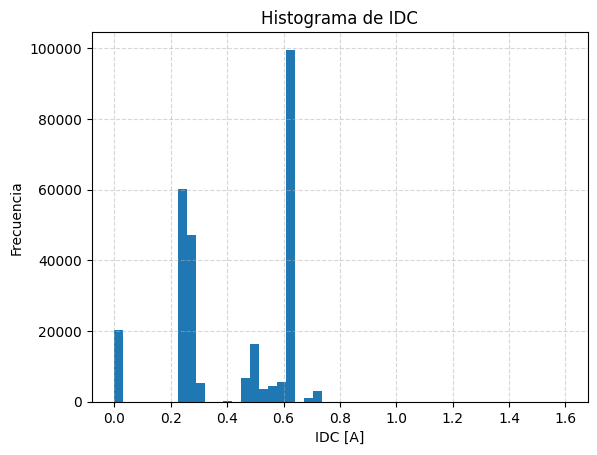

In [5]:
import matplotlib.pyplot as plt

xmin, xmax, nbins = 0.0, 1.6, 50
dt = (xmax - xmin) / nbins
bins = [xmin + dt * k for k in range(nbins + 1)]
df["IDC"].hist(bins=bins)
plt.xlabel("IDC [A]")
plt.ylabel("Frecuencia")
plt.title("Histograma de IDC")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


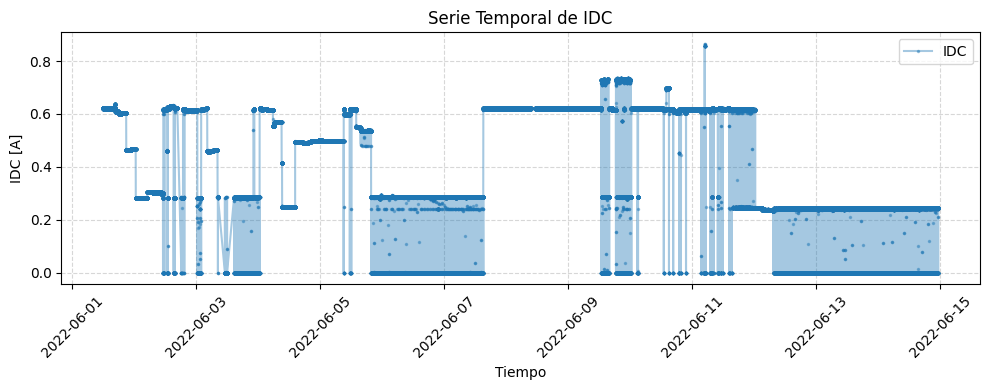

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["IDC"], linestyle="-", marker=".", markersize=3, label="IDC", alpha=0.4)
plt.xlabel("Tiempo")
plt.ylabel("IDC [A]")
plt.title("Serie Temporal de IDC")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


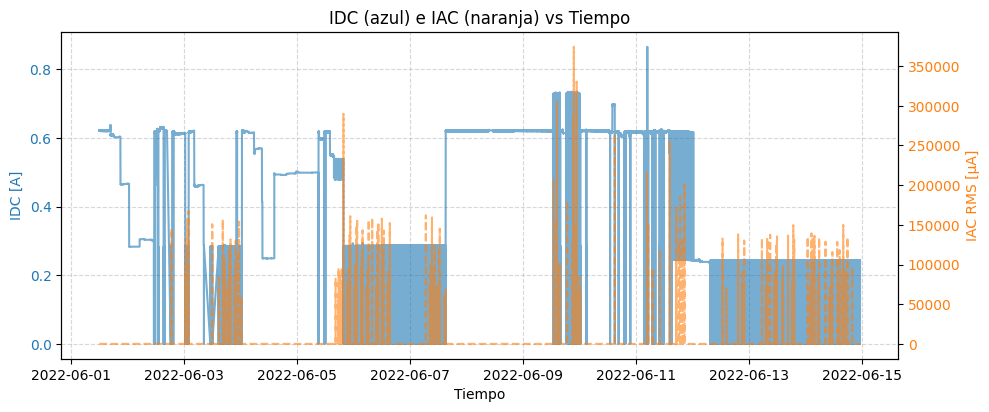

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(df.index, df["IDC"], color="tab:blue", label="IDC [A]", alpha=0.6)
ax1.set_xlabel("Tiempo")
ax1.set_ylabel("IDC [A]", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, which="both", linestyle="--", alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(df.index, df["IAC"] * 1e6, color="tab:orange", linestyle="--", label="IAC [µA]", alpha=0.6)
ax2.set_ylabel("IAC RMS [µA]", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.tight_layout()
plt.title("IDC (azul) e IAC (naranja) vs Tiempo")
plt.show()


##  Cruce con datos Beam

In [17]:
beam_data = pd.read_csv("./csv/beam_data.csv")
beam_data.head()

,Time,TID,HEH,N1MeV,run_group
0,2022-05-25 10:09:53.517351680,488.022822,1.060544e+12,5.839896e+12,run_7
1,2022-05-25 10:10:44.276027648,488.027711,1.060544e+12,5.841454e+12,run_7
2,2022-05-25 10:11:35.034703616,488.025729,1.060544e+12,5.842470e+12,run_7
3,2022-05-25 10:12:25.793379328,488.033527,1.060544e+12,5.843457e+12,run_7
4,2022-05-25 10:13:16.552055040,488.017482,1.060544e+12,5.844933e+12,run_7


## Latch-Up

In [8]:
import numpy as np
# 1) Estadísticos descriptivos básicos de IDC
descr = df["IDC"].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print("----- Estadísticos de IDC -----")
print(descr)

# 2) Histograma fino para identificar modos (picos) en la distribución de IDC
#    Definimos un número elevado de bins para capturar picos estrechos:
nbins = 200
hist_vals, bin_edges = np.histogram(df["IDC"].dropna(), bins=nbins, range=(0, df["IDC"].max()))

# 3) Encontrar los índices de los 3 picos más altos del histograma
peak_indices = np.argsort(hist_vals)[-3:][::-1]  # Tres bins con mayor frecuencia
peak_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in peak_indices]

print("\n----- Tres modos principales de IDC (centros de bins) -----")
for i, center in enumerate(peak_centers, 1):
    count = hist_vals[peak_indices[i-1]]
    print(f"Modo {i}: IDC ≈ {center:.4f} A  (conteo en bin: {count})")

# 4) Percentiles clave para entender dispersión y posibles outliers
p_vals = {p: np.percentile(df["IDC"].dropna(), p) for p in [1, 5, 10, 90, 95, 99]}
print("\n----- Percentiles seleccionados de IDC -----")
for p, val in p_vals.items():
    print(f"{p}° percentil: {val:.4f} A")

----- Estadísticos de IDC -----
count    273858.000000
mean          0.414468
std           0.202282
min          -0.000200
1%            0.000000
5%            0.000000
25%           0.243300
50%           0.463200
75%           0.619000
95%           0.622800
99%           0.725200
max           0.865400
Name: IDC, dtype: float64

----- Tres modos principales de IDC (centros de bins) -----
Modo 1: IDC ≈ 0.6209 A  (conteo en bin: 64712)
Modo 2: IDC ≈ 0.2445 A  (conteo en bin: 47959)
Modo 3: IDC ≈ 0.2834 A  (conteo en bin: 26651)

----- Percentiles seleccionados de IDC -----
1° percentil: 0.0000 A
5° percentil: 0.0000 A
10° percentil: 0.2423 A
90° percentil: 0.6224 A
95° percentil: 0.6228 A
99° percentil: 0.7252 A



Podemos concluir:

- **“Off”** (latch-up/protección) ocurre cuando `IDC ≈ 0 A`. De hecho, el percentil 5% y 1% son 0 A.  
- **“Idle principal”** se ubica alrededor de 1.26 A (50% y 75% en ~1.257–1.260).  
- Existe un segundo “estado intermedio” alrededor de 0.65 A (25% en ~0.6766, 10% en ~0.4473).

Para detectar **caídas repentinas de “idle principal” → “off”** definimos:

- Umbral de **off**:  
  $$ \text{OFF\_TH} = 0.01\;\text{A} $$
  (cualquier corriente menor a 0.01 A la consideramos apagado / latch-up).

- Rango de **idle principal**:  
  $$ \text{IDLE\_LOW} = 1.20\;\text{A},\quad \text{IDLE\_HIGH} = 1.30\;\text{A} $$
  (todo valor en [1.20, 1.30] A lo consideramos “en operación normal”).

De este modo nos aseguramos de que sólo se detecten transiciones cuando está realmente en modo “idle principal” y cae a “off”, ignorando el estado intermedio (~0.65 A) que corresponde a otras fases de consumo.


In [9]:
import numpy as np

# 1) Definición de umbrales basados en el análisis distribuido de IDC
OFF_TH = 0.01       # < 0.01 A → se considera “off” (protección/latch-up)
IDLE_LOW = 1.20     # ≥ 1.20 A
IDLE_HIGH = 1.30    # ≤ 1.30 A

# 2) Extraer timestamps de eventos “idle principal → off”
events = []
prev_idle = False

# Convertimos la serie “IDC” en un array para evitar múltiples indexaciones
idc_arr = df["IDC"].values
times  = df.index.to_numpy()

for i in range(1, len(idc_arr)):
    prev = idc_arr[i - 1]
    curr = idc_arr[i]
    t    = times[i]
    
    # Estado “idle principal” en la muestra previa
    if IDLE_LOW <= prev <= IDLE_HIGH:
        prev_idle = True
    else:
        prev_idle = False
    
    # Detectar transición “idle principal → off”
    if prev_idle and (curr < OFF_TH):
        # Buscar recuperación: siguiente instantánea con IDC ≥ IDLE_LOW
        # (a partir de i+1 en adelante)
        resto_idx = np.where(idc_arr[i+1:] >= IDLE_LOW)[0]
        if resto_idx.size > 0:
            j = resto_idx[0] + (i + 1)
            t_rec = times[j]
            duration_s = (t_rec - t).astype('timedelta64[s]').astype(int)
            events.append({
                "Time_event": t,
                "Duración_s": duration_s,
                "Idle_previo": prev,
                "Off_detectado": curr,
                "Recuperación_en": t_rec,
                "IDC_recuperación": idc_arr[j]
            })

# 3) Validaciones y salida
if not events:
    print("⚠️ No se detectaron transiciones ‘idle principal → off’.")
else:
    eventos_df = pd.DataFrame(events)
    print(f"Se detectaron {len(events)} eventos de latch-up.\n")
    print("Primeros 5 eventos:\n", eventos_df.head())

# 4) Opcional: construir array 'dose_to_failure' tras haberse fusionado con beam
#    Asumimos que tras la fusión, 'df' tiene columna 'TID'.
#    Si no existe, se lanzará KeyError.
if "TID" in df.columns and events:
    dose_to_failure = np.array([df.loc[e["Time_event"], "TID"] for e in events])
    print("\nPrimeras 5 dosis al fallo (Gy):", dose_to_failure[:5])
else:
    dose_to_failure = np.array([])
    if not events:
        print("No hay eventos para extraer dosis.")
    else:
        raise KeyError("La columna 'TID' no está presente en el DataFrame.")

# 5) Mensajes de diagnóstico sobre formatos
if dose_to_failure.size > 0:
    if np.any(np.isnan(dose_to_failure)):
        raise ValueError("⚠️ Se encontraron valores NaN en 'dose_to_failure'. Revisar fusión con beam.")
    if np.any(dose_to_failure <= 0):
        raise ValueError("⚠️ Hay dosis ≤ 0 en 'dose_to_failure'. Revisar datos de beam.")


⚠️ No se detectaron transiciones ‘idle principal → off’.
No hay eventos para extraer dosis.


In [10]:
eventos = []
df_shift = df["IDC"].shift(1)

# filtros
prev_lower 

for t in df.index[1:]:
    prev, curr = df_shift.loc[t], df["IDC"].loc[t]
    print(prev, curr)
    # Detecta caída repentina idle → apagado
    if (prev >= 0.06 and prev <= 0.12) and (curr < 0.01):
        # Buscar momento de recuperación (idle → corriente ≥ 0.06 A)
        recuperación = df.index[df.index.get_loc(t) + 1:]
        recuperación = recuperación[df["IDC"].loc[recuperación] >= 0.06]
        if len(recuperación) > 0:
            t_rec = recuperación[0]
            duración = (t_rec - t).total_seconds()
            eventos.append({"Time_event": t, "Duración_s": duración})


NameError: name 'prev_lower' is not defined

In [ ]:
eventos

[]

# Modelado de Resiliencia por Latch-Up

Definimos la variable aleatoria \(D\) = “dosis hasta latch-up”. A partir de los datos obtenidos cruzando DMM vs beam, extraemos el vector \(\{d_i\}\).

- **Exponencial (tasa constante):**  
  $$f(d) = \lambda e^{-\lambda d}, \quad S(d) = e^{-\lambda d}$$  
  $\displaystyle \hat\lambda = 1 / \bar d$.

- **Weibull (envejecimiento o efecto inicial):**  
  $$f(d) = \frac{k}{\eta}\Bigl(\frac{d}{\eta}\Bigr)^{k-1}e^{-(d/\eta)^k}, \quad S(d) = e^{-(d/\eta)^k}$$  
  $\;k\neq 1$ ajusta “drift” de la tasa de falla.

El pipeline espera un arreglo NumPy con dosis al primer latch-up (Gy). Si el formato es distinto (por ejemplo, strings en lugar de floats, o timestamps mal convertidos), las funciones de ajuste fallarán. En la siguiente celda definimos las funciones y en la última hacemos comprobaciones sobre el formato de `dose_to_failure` antes de ajustar los modelos.


In [ ]:
# --- Funciones de Ajuste y Supervivencia ---

import numpy as np
import scipy.stats as st

def fit_exponential(doses, alpha=0.05):
    """Ajusta exponencial: retorna λ̂ y su IC95%."""
    if len(doses)==0:
        raise ValueError("El arreglo de dosis está vacío.")
    if np.any(doses <= 0):
        raise ValueError("Todas las dosis deben ser positivas.")
    lam_hat = 1.0 / doses.mean()
    n = len(doses)
    sum_d = doses.sum()
    chi2_l = st.chi2.ppf(alpha/2, 2*n)
    chi2_u = st.chi2.ppf(1 - alpha/2, 2*n)
    lam_ci = (chi2_l/(2*sum_d), chi2_u/(2*sum_d))
    return lam_hat, lam_ci

def fit_weibull(doses, n_boot=1000, alpha=0.05, seed=42):
    """Ajusta Weibull (shape k, scale η) y calcula IC95% por bootstrap."""
    if len(doses)==0:
        raise ValueError("El arreglo de dosis está vacío.")
    if np.any(doses <= 0):
        raise ValueError("Todas las dosis deben ser positivas.")
    k_hat, loc_hat, eta_hat = st.weibull_min.fit(doses, floc=0)
    # Bootstrap para IC
    rng = np.random.default_rng(seed)
    n = len(doses)
    params = np.zeros((n_boot, 2))
    for i in range(n_boot):
        sample = rng.choice(doses, size=n, replace=True)
        k_b, loc_b, eta_b = st.weibull_min.fit(sample, floc=0)
        params[i] = (k_b, eta_b)
    k_ci = np.percentile(params[:,0], [100*alpha/2, 100*(1-alpha/2)])
    eta_ci = np.percentile(params[:,1], [100*alpha/2, 100*(1-alpha/2)])
    return (k_hat, eta_hat), (tuple(k_ci), tuple(eta_ci))

def S_exponential(d, lam):
    return np.exp(-lam * d)

def S_weibull(d, k, eta):
    return np.exp(-(d/eta)**k)


# ---  Ejecución  ---
# dose_to_failure = np.array([...])  # Dosis en Gy
lam_hat, lam_ci = fit_exponential(dose_to_failure)
print("λ̂ =", lam_hat, "IC95% λ:", lam_ci)

(k_hat, eta_hat), (k_ci, eta_ci) = fit_weibull(dose_to_failure)
print("k̂ =", k_hat, "η̂ =", eta_hat, "IC95% k:", k_ci, "IC95% η:", eta_ci)

d_vals = np.array([0.5, 1.0, 2.0])
print("S_exp:", S_exponential(d_vals, lam_hat))
print("S_weibull:", S_weibull(d_vals, k_hat, eta_hat))

NameError: name 'dose_to_failure' is not defined